In [1]:
import io
import os
import time
import hashlib
import operator
from collections import Counter
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cv2
from cv2 import img_hash
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from skimage.util import montage
import torch
from torch.autograd import Variable

from utils import overlay_tag_pairs
from utils import overlay_tag_maps
from utils import generate_overlay_tag_slices
from utils import generate_pair_tag_lookup
from utils import get_tile
from utils import channel_shift
from utils import read_duplicate_truth
from utils import update_duplicate_truth
from utils import read_image_duplicate_tiles
from utils import write_image_duplicate_tiles
from utils import read_image_image_duplicate_tiles
from utils import update_image_image_duplicate_tiles
from utils import generate_overlay_tag_nines_mask

from test_friend_circles import SDCImageContainer

from dupnet import load_checkpoint

%matplotlib inline
%reload_ext autoreload
%autoreload 2

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
montage_pad = lambda x, *args, **kwargs: montage(x, padding_width=10, *args, **kwargs)

ship_dir = "data/input"
train_image_dir = os.path.join(ship_dir, "train_768")
train_mask_dir = os.path.join(ship_dir, 'train_masks_768')
image_md5hash_grids_file = os.path.join("data", "image_md5hash_grids.pkl")
image_bm0hash_grids_file = os.path.join("data", "image_bm0hash_grids.pkl")
image_entropy_grids_file = os.path.join("data", "image_entropy_grids.pkl")
image_duplicate_tiles_file = os.path.join("data", "image_duplicate_tiles.txt")
image_image_duplicate_tiles_file = os.path.join("data", "image_image_duplicate_tiles.txt")
duplicate_truth_file = os.path.join('data', 'duplicate_truth.txt')

overlay_tag_slices = generate_overlay_tag_slices()
pair_tag_lookup = generate_pair_tag_lookup()

In [2]:
sdcic = SDCImageContainer(train_image_dir)
sdcic.load_3x3_grids(
    image_md5hash_grids_file,
    image_bm0hash_grids_file,
    image_entropy_grids_file,
    image_duplicate_tiles_file)

100%|██████████| 192555/192555 [00:14<00:00, 13371.05it/s]


## Find overlapping images using hashlib
Update: The values between two supposedly exact 256x256 crops are not exact (See below).  Not sure how to use a "friend circles" algorithm for overlap testing/grouping.  I defer this work to a later date.

In [58]:
md5hash_dict = defaultdict(list)
img_ids = os.listdir(train_image_dir)

for img_id in tqdm_notebook(img_ids):
    for ij, h in sdcic.tile_md5hash_grids[img_id].items():
        md5hash_dict[h].append(img_id)

dup_counts_dict = defaultdict(int)
for key, dups in md5hash_dict.items():
    dup_counts_dict[len(dups)] += 1

sorted_bin_sizes = sorted(dup_counts_dict.items())
sorted_bin_sizes

[(1, 1655378),
 (2, 26274),
 (3, 3390),
 (4, 1658),
 (5, 366),
 (6, 505),
 (7, 86),
 (8, 30),
 (9, 36),
 (30, 1),
 (205, 1),
 (304, 1),
 (387, 1),
 (447, 1),
 (868, 1)]

Lets plot our groupings and make sure images have a common tile.

26027fa3 9 1561
bffe2d47 9 2475
4b3b2fd0 9 13730
5a362dec 9 14780
049fa8b2 9 15018
47631e13 9 15171
b99ffdb7 9 20763
6ffbeef5 9 24096
91b79400 9 24099
90ca3d2d 9 24883
dccbcc2c 9 30803
dccbcc2c 9 30803
['bc36bd5b2.jpg', 'bf8b951e4.jpg', '712d262e5.jpg', 'da77a989b.jpg', '195f6f0e5.jpg', 'fe02d4aaa.jpg', 'b9d9f8f88.jpg', '7a2c504f7.jpg', '071127598.jpg']
(9, 768, 768, 3)
(2304, 2304, 3) float32


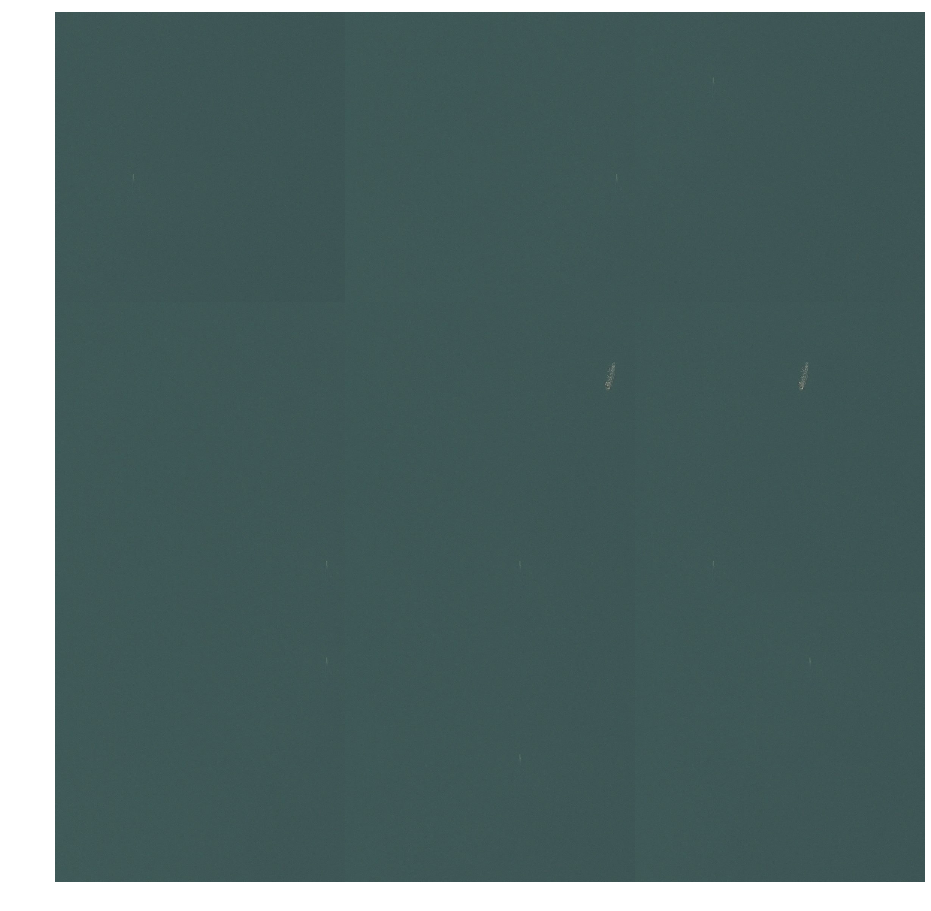

In [56]:
batch_size = 9
skip = 10
ii = 0
jj = 0
batch_limit = 9
samples_images = np.empty((batch_limit, 768, 768, 3), dtype=np.float32)

for key, dups in md5hash_dict.items():
    ii += 1
    if len(dups) == batch_size:
        print(key, len(dups), ii)
        if jj == min(dup_counts_dict[len(dups)], skip):
            dups0 = list(set(dups))
            print(key, len(dups0), ii)
            for img_id in dups0:
                print(img_id, )
            break
        jj += 1

for i, c_img_id in enumerate(dups0[:batch_limit]):
    c_img = cv2.cvtColor(sdcic.get_img(c_img_id), cv2.COLOR_BGR2RGB)
    samples_images[i] = c_img.astype(np.float32) / 255.0

batch_rgb = montage_rgb(samples_images)
print(samples_images.shape)
print(batch_rgb.shape, batch_rgb.dtype)

fig, ax = plt.subplots(1, 1, figsize = (16, 16))
ax.imshow(batch_rgb, vmin=0, vmax=1)
plt.axis('off')
# plt.savefig(os.path.join('out', BASE_MODEL, f"{train_meta_filebase}_{score_str}_batch_{BATCH_NUM}.jpg"))
plt.show()

## Find overlapping images using cv2.img_hash

In [49]:
bm0hash_dict = defaultdict(list)
img_ids = os.listdir(train_image_dir)

for img_id in tqdm_notebook(img_ids):
    for ij, h in sdcic.tile_bm0hash_grids[img_id].items():
        bm0hash_dict[tuple(h)].append(img_id)  # hex

dup_counts_dict = defaultdict(int)
for key, dups in bm0hash_dict.items():
    dup_counts_dict[len(dups)] += 1

sorted_bin_sizes = sorted(dup_counts_dict.items())
sorted_bin_sizes

[(1, 713030),
 (2, 251341),
 (3, 66279),
 (4, 24633),
 (5, 10371),
 (6, 13009),
 (7, 4752),
 (8, 2550),
 (9, 3401),
 (10, 3),
 (11, 7),
 (12, 8),
 (13, 1),
 (16, 2),
 (17, 1),
 (18, 6),
 (20, 1),
 (23, 2),
 (24, 2),
 (27, 1),
 (29, 2),
 (30, 1),
 (31, 2),
 (36, 1),
 (37, 1),
 (45, 1),
 (46, 1),
 (48, 1),
 (49, 1),
 (51, 1),
 (57, 1),
 (60, 1),
 (61, 1),
 (68, 1),
 (69, 1),
 (82, 1),
 (86, 1),
 (89, 1),
 (96, 1),
 (99, 1),
 (106, 1),
 (110, 1),
 (112, 1),
 (118, 1),
 (135, 1),
 (137, 1),
 (157, 1),
 (160, 1),
 (194, 1),
 (206, 1),
 (221, 1),
 (267, 1),
 (387, 1),
 (468, 1),
 (1211, 1)]

(248, 123, 157, 107, 84, 41, 154, 170, 16, 239, 144, 183, 0, 237, 142, 238, 48, 150, 35, 153, 139, 169, 9, 251, 24, 165, 141, 213, 225, 191, 20, 205) 9 111
(128, 112, 128, 120, 128, 57, 128, 49, 128, 25, 128, 13, 128, 95, 128, 207, 128, 7, 0, 7, 1, 99, 0, 119, 0, 31, 128, 31, 192, 143, 192, 207) 9 289
(128, 112, 128, 120, 128, 57, 128, 49, 128, 25, 128, 13, 128, 95, 128, 207, 128, 7, 0, 7, 1, 99, 0, 119, 0, 31, 128, 31, 192, 143, 192, 207) 9 289
['30207273a.jpg', 'd61426b8c.jpg', 'af0f0ea37.jpg', 'c577f6066.jpg', '0c36ac8a8.jpg', 'a901aab23.jpg', '9568c7de7.jpg', '2f3fce1b8.jpg', '9f75e7cf4.jpg']
(9, 768, 768, 3)
(2304, 2304, 3) float32


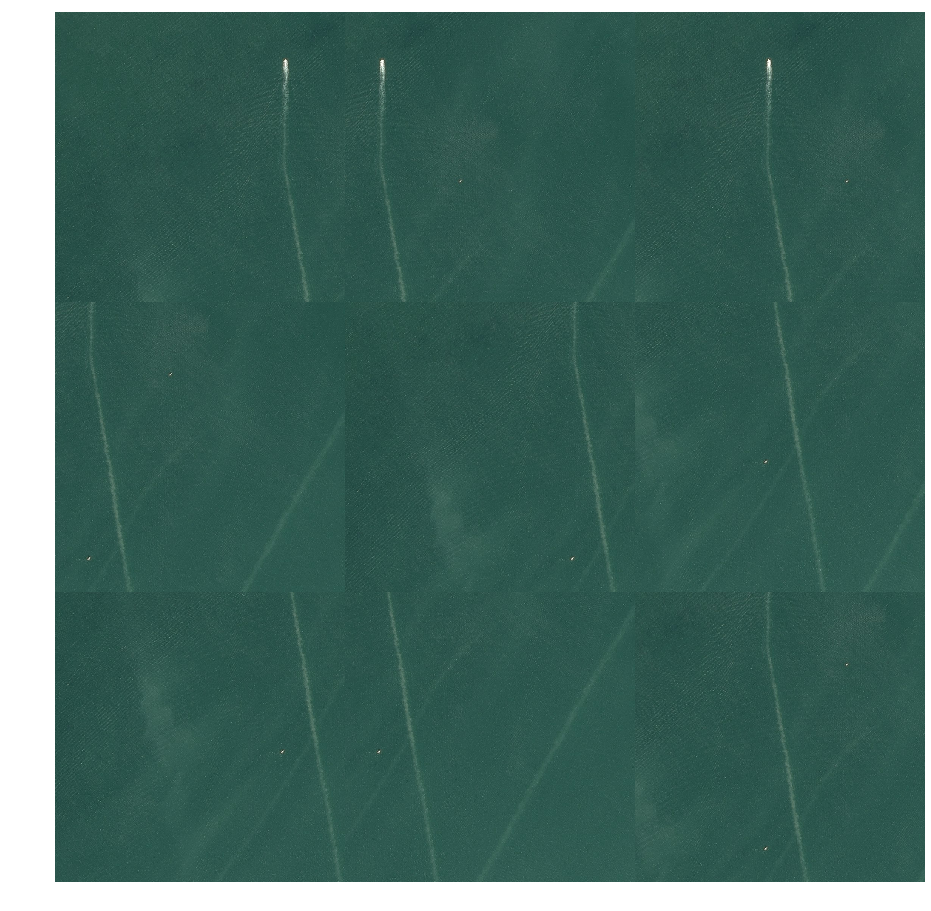

In [51]:
batch_size = 9
skip = 10
ii = 0
jj = 0
batch_limit = 9
samples_images = np.empty((batch_limit, 768, 768, 3), dtype=np.float32)

for key, dups in bm0hash_dict.items():
    ii += 1
    if len(dups) == batch_size:
        print(key, len(dups), ii)
        if jj == min(dup_counts_dict[len(dups)], skip):
            dups0 = list(set(dups))
            print(key, len(dups0), ii)
            print(dups0)
            break
        jj += 1

for i, c_img_id in enumerate(dups0[:batch_limit]):
    c_img = cv2.cvtColor(sdcic.get_img(c_img_id), cv2.COLOR_BGR2RGB)
    samples_images[i] = c_img.astype(np.float32) / 255.0

batch_rgb = montage_rgb(samples_images)
print(samples_images.shape)
print(batch_rgb.shape, batch_rgb.dtype)

fig, ax = plt.subplots(1, 1, figsize = (16, 16))
ax.imshow(batch_rgb, vmin=0, vmax=1)
plt.axis('off')
# plt.savefig(os.path.join('out', BASE_MODEL, f"{train_meta_filebase}_{score_str}_batch_{BATCH_NUM}.jpg"))
plt.show()

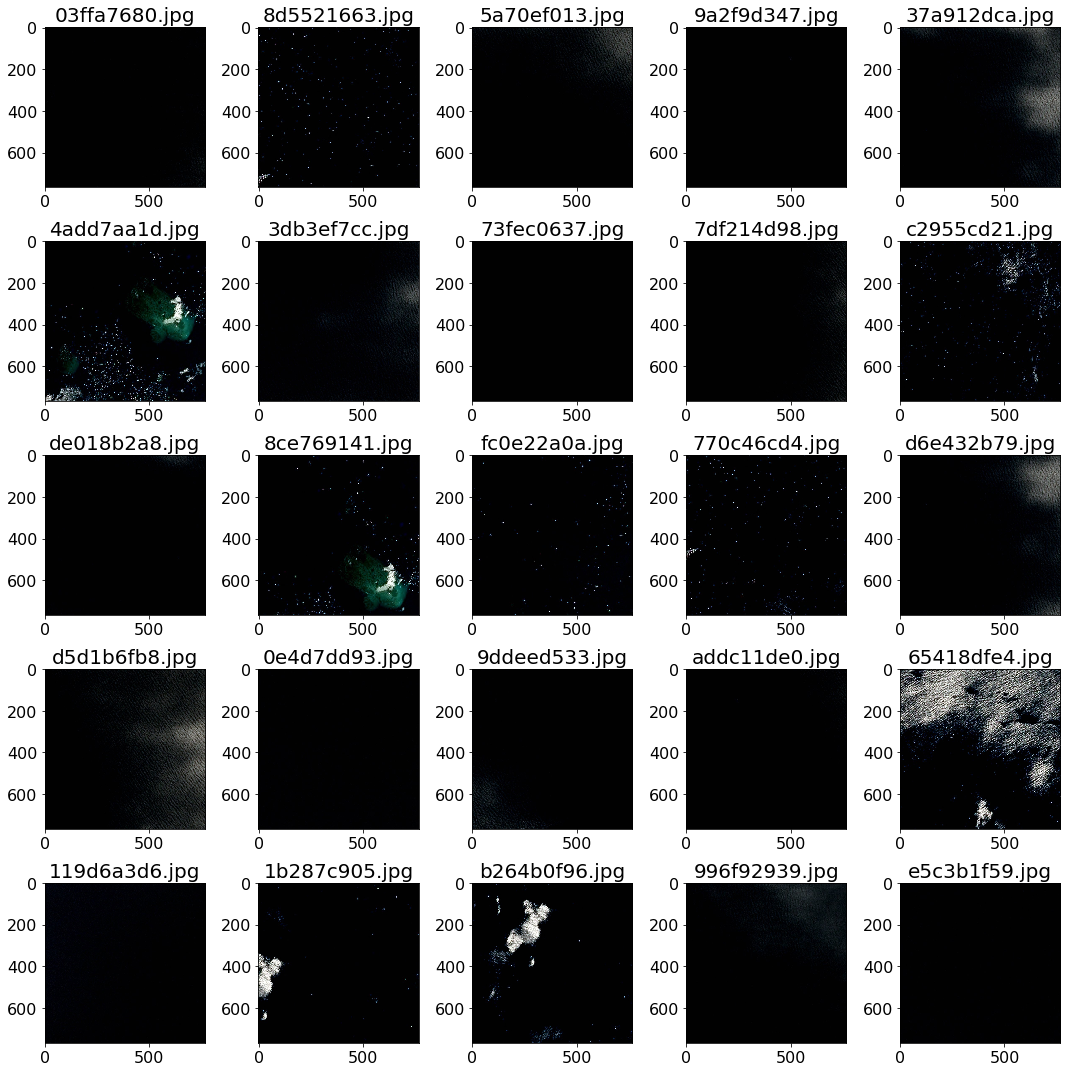

In [4]:
black_images = ['03ffa7680.jpg', '8d5521663.jpg', '5a70ef013.jpg', '9a2f9d347.jpg', '37a912dca.jpg', '4add7aa1d.jpg', '3db3ef7cc.jpg', '73fec0637.jpg', '7df214d98.jpg', 'c2955cd21.jpg', 'de018b2a8.jpg', '8ce769141.jpg', 'fc0e22a0a.jpg', '770c46cd4.jpg', 'd6e432b79.jpg', 'd5d1b6fb8.jpg', '0e4d7dd93.jpg', '9ddeed533.jpg', 'addc11de0.jpg', '65418dfe4.jpg', '119d6a3d6.jpg', '1b287c905.jpg', 'b264b0f96.jpg', '996f92939.jpg', 'e5c3b1f59.jpg']
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, img_id in enumerate(black_images):
    img = cv2.imread(os.path.join(train_image_dir, img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_title(img_id)
plt.tight_layout()

In [3]:
def fuzzy_compare(tile1, tile2):
    maxab = np.max(np.stack([tile1, tile2]), axis=0)
    a = maxab - tile2
    b = maxab - tile1
    ab = a + b
    n = np.prod(maxab.shape)
    return np.sum(255 - ab) / (255 * n)

def fuzzy_diff(tile1, tile2):
    maxab = np.max(np.stack([tile1, tile2]), axis=0)
    a = maxab - tile2
    b = maxab - tile1
    ab = a + b
    return np.sum(ab)

def slice_from_large(img, i, j, sz=256):
    tile = get_tile(img, i, j, sz=sz)
    return cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)

def get_overlay_score(img1, img2, overlay_tag, sz=256, mode=0):
    overlay_map1 = overlay_tag_maps[overlay_tag]
    overlay_map2 = overlay_tag_maps[overlay_tag_pairs[overlay_tag]]
    bmh1_list = []
    bmh2_list = []
    for ((i, j), (k, l)) in zip(overlay_map1, overlay_map2):
        tile1 = get_tile(img1, i, j, sz=sz)
        tile2 = get_tile(img2, k, l, sz=sz)
        bmh1 = img_hash.blockMeanHash(tile1, mode=mode)
        bmh2 = img_hash.blockMeanHash(tile2, mode=mode)
        bmh1_list.append(bmh1)
        bmh2_list.append(bmh2)
    bmh1_arr = np.vstack(bmh1_list)
    bmh2_arr = np.vstack(bmh2_list)
    score = fuzzy_compare(bmh1_arr, bmh2_arr)
    return score

def get_tile_scores(img1, img2, overlay_tag, sz=256, mode=0):    
    overlay_map1 = overlay_tag_maps[overlay_tag]
    overlay_map2 = overlay_tag_maps[overlay_tag_pairs[overlay_tag]]
    scores = []
    for ((i, j), (k, l)) in zip(overlay_map1, overlay_map2):
        tile1 = get_tile(img1, i, j, sz=sz)
        tile2 = get_tile(img2, k, l, sz=sz)
        bmh1 = img_hash.blockMeanHash(tile1, mode=mode)
        bmh2 = img_hash.blockMeanHash(tile2, mode=mode)
        score = fuzzy_compare(bmh1, bmh2)
        scores.append(score)
    return scores

def get_pixel_scores(img1, img2, overlay_tag, sz=256):
    overlay_map1 = overlay_tag_maps[overlay_tag]
    overlay_map2 = overlay_tag_maps[overlay_tag_pairs[overlay_tag]]
    scores = []
    for ((i, j), (k, l)) in zip(overlay_map1, overlay_map2):
        tile1 = get_tile(img1, i, j, sz=sz)
        tile2 = get_tile(img2, k, l, sz=sz)
        score = fuzzy_diff(tile1, tile2)
        scores.append(score)
    return np.array(scores)

def get_dcnn_scores(img1, img2, overlay_map, model, sz=256):    
    overlay_map1 = overlay_tag_maps[overlay_tag]
    overlay_map2 = overlay_tag_maps[overlay_tag_pairs[overlay_tag]]
    X_list = []
    for ((i, j), (k, l)) in zip(overlay_map1, overlay_map2):
        tile1 = slice_from_large(img1, i, j, sz=sz).astype(np.float32) / 255.0
        tile2 = slice_from_large(img2, k, l, sz=sz).astype(np.float32) / 255.0
        X = np.dstack([tile1, tile2])
        X = X.transpose((2, 0, 1))
        X_list.append(X)

    X_arr = np.stack(X_list)
    inputs = torch.from_numpy(X_arr)
    inputs = inputs.to(device)
    
    with torch.set_grad_enabled(False):
        val_outputs = model(inputs)

#     y_pred = val_outputs > 0.5
    return val_outputs[:, 0].cpu().numpy()

In [4]:
dup_truth = read_duplicate_truth(duplicate_truth_file)
len(dup_truth)

11685

In [87]:
device = torch.device("cuda")          # a CUDA device object
model = load_checkpoint('out/dup_model.last.pth')
model.cuda()
print(model)

DupCNN(
  (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [89]:
dup_truth1 = {}
for key, is_dup in dup_truth.items():
    if is_dup:
        dup_truth1[key] = is_dup
len(dup_truth1)

1667

In [91]:
ii = 1
dup_dict = {}
for (img1_id, img2_id, overlay_tag), is_dup in dup_truth1.items():
    ii += 1
    if img1_id > img2_id:
        img1_id, img2_id = img2_id, img1_id
        overlay_tag = overlay_tag_pairs[overlay_tag]

    if (img1_id, img2_id, overlay_tag) in dup_dict:
        continue

    img1 = cv2.imread(os.path.join(train_image_dir, img1_id))
    img2 = cv2.imread(os.path.join(train_image_dir, img2_id))

    image_score = get_overlay_score(img1, img2, overlay_tag)
    pixel_scores = get_pixel_scores(img1, img2, overlay_tag)
    tiles_score = get_tile_scores(img1, img2, overlay_tag)
    dcnn_scores_raw = get_dcnn_scores(img1, img2, overlay_tag, model)
    dcnn_scores = (dcnn_scores_raw > 0.5) * 1

    dup_dict[(img1_id, img2_id, overlay_tag)] = (is_dup, image_score, min(tiles_score))

    if is_dup == np.min(dcnn_scores):
        continue

#     print(f"{ii:>3} {img1_id} {img2_id}               {is_dup} {np.min(dcnn_scores)} {image_score:6.4f}, {min(tiles_score):6.4f}]", pixel_scores, dcnn_scores_raw)
    print(f"{ii:>3} {img1_id} {img2_id} {overlay_tag} {is_dup} {np.min(dcnn_scores)}", pixel_scores)
#     print(dcnn_scores)
#     print(dcnn_scores_raw)

  4 000155de5.jpg 32018f9a6.jpg 0112 1 1 [ 16 196 645  51]
[1 1 1 1]
[1. 1. 1. 1.]
  8 000155de5.jpg 07ae92b4f.jpg 0021 1 1 [ 24  10  25  62 136  32]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
 12 000194a2d.jpg f3cbca9b6.jpg 0222 1 1 [  0 739 194]
[1 1 1]
[0.9723298 0.9999938 1.       ]
 16 000194a2d.jpg 384765ab2.jpg 1022 1 1 [152   2   0   0   0   0]
[1 1 1 1 1 1]
[0.99964666 0.99995697 0.9999938  0.9999044  0.9999479  1.        ]
 20 0002756f7.jpg dac54e322.jpg 0112 1 1 [863 256 623 222]
[1 1 1 1]
[1. 1. 1. 1.]
 24 0002d0f32.jpg 59662af16.jpg 1021 1 1 [2604 2241 1172  784]
[1 1 1 1]
[1. 1. 1. 1.]
 28 00031f145.jpg f216d616c.jpg 0012 1 1 [2062 2522 2505 2202 2540 2329]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
 32 000532683.jpg 5716a88a1.jpg 0002 1 1 [73 40 59]
[1 1 1]
[1. 1. 1.]
 36 000532683.jpg 7953c7337.jpg 0112 1 1 [ 46  61  69 206]
[1 1 1 1]
[1. 1. 1. 1.]
 40 000532683.jpg 1061ac111.jpg 1022 1 1 [197  25  38  12   3 764]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
 44 00053c6ba.jpg 79fb486b1.jpg 1122 1 1

348 003d0a956.jpg 4d70d69f0.jpg 0021 1 1 [ 403  161  857  369 1233  176]
[1 1 1 1 1 1]
[1.         1.         0.99999917 1.         0.99999726 1.        ]
352 003e2c95d.jpg 908fa51a4.jpg 0011 1 1 [ 842 1377  545 1238]
[1 1 1 1]
[1. 1. 1. 1.]
356 003e929b2.jpg 378718b18.jpg 0112 1 1 [1788  471 1506 2529]
[1 1 1 1]
[1. 1. 1. 1.]
360 0040cf4e9.jpg e0c5cce1a.jpg 2022 1 1 [1543 1783  601]
[1 1 1]
[0.9999994  0.99999917 0.99999905]
364 004141855.jpg adce6fc0d.jpg 0222 1 1 [225 235 197]
[1 1 1]
[1.        0.9996798 1.       ]
368 004141855.jpg b23c778fd.jpg 0012 1 1 [  4   0 176 158  27  39]
[1 1 1 1 1 1]
[1.         1.         1.         1.         1.         0.99967957]
372 0041d7084.jpg 4e39a2e5a.jpg 0002 1 1 [2763  482  816]
[1 1 1]
[1.        0.9999846 0.999997 ]
376 0041d7084.jpg b5e59954c.jpg 0012 1 1 [1198  271  397 1012 1558 1208]
[1 1 1 1 1 1]
[1.         0.9999846  0.999997   0.99999833 0.9999981  0.9999989 ]
380 0042da6d5.jpg cd03b08cf.jpg 0021 1 1 [214  40   0  24  12  36]
[1 1 1

676 008401010.jpg d4f9fb514.jpg 1021 1 1 [3080 2533 3101 2750]
[1 1 1 1]
[1. 1. 1. 1.]
680 008605bcf.jpg 87bd9c92b.jpg 0021 1 1 [133 290 384 380 195 307]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
684 0086f828b.jpg 878136afb.jpg 1021 1 1 [29 43 24 11]
[1 1 1 1]
[1. 1. 1. 1.]
688 0086f828b.jpg 5f6246e51.jpg 1022 1 1 [ 0 23 37 23  7  5]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
692 00b872d8e.jpg fd69a195a.jpg 0012 1 1 [3614 3457 2526 2188 2183 1923]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
696 00db890ad.jpg ede7a7bd0.jpg 0021 1 1 [2978 3704 2945 3193 3260 2471]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
700 010e15afe.jpg 723a8fabf.jpg 0021 1 1 [2185 1821 2032  115   76  348]
[1 1 1 1 1 1]
[1.         1.         1.         0.99995697 0.9999764  0.9999893 ]
704 01178499a.jpg 7a7a0034a.jpg 0012 1 1 [33664 33664 33664     0     6     0]
[1 1 1 1 1 1]
[1.         0.9999999  1.         0.9999306  0.99997103 0.9999207 ]
708 012735107.jpg 0cc08f1f5.jpg 0122 1 1 [ 731 1426  487  760  655  760]
[1 1 1 1 1 1]
[1.        1.        

972 17ca5a093.jpg 8395e055c.jpg 0021 1 1 [3095 2840 3802 3733 2219 2456]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
976 1809c33ad.jpg b884f1b97.jpg 2022 1 1 [374359 370733 378089]
[1 1 1]
[1. 1. 1.]
980 18722fb07.jpg dd9316d80.jpg 0022 1 1 [1991222 1983381 1991086 1992635 1971795 1958188 1952566 1980979 1971905]
[1 1 1 1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
984 19232e449.jpg 29a6548a3.jpg 0020 1 1 [10474 11695 10641]
[1 1 1]
[1. 1. 1.]
988 19d70773e.jpg 729e10466.jpg 0222 1 1 [ 9538  9629 11615]
[1 1 1]
[1. 1. 1.]
992 1a1adb3a7.jpg e4ca911ee.jpg 0002 1 1 [ 8207 12669 11116]
[1 1 1]
[1. 1. 1.]
996 1ab13c924.jpg fa09406d3.jpg 0112 1 1 [360479 357564 356432 362499]
[1 1 1 1]
[1. 1. 1. 1.]
1000 1adbdab0d.jpg 41e4c7a01.jpg 0021 1 1 [1708  783 1162 2347 2321  814]
[1 1 1 1 1 1]
[1.        0.9999999 1.        1.        1.        1.       ]
1004 1c4761fa0.jpg fa90f1adb.jpg 0012 1 1 [3958 2365 2980 2206 2976 2513]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
1008 1d3faae80.jpg f14d7ef54.jpg 0021 1 1 [385051 387

1264 55a0e59a1.jpg b9ad91ade.jpg 0022 1 1 [2110052 1972303 2183353 2082445 1985009 2008092 1897129 1912361 1873502]
[1 1 1 1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
1268 569be1cad.jpg e6b7c65ac.jpg 0021 1 1 [1757007 1777492 1847267 1873786 1744755 1728590]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
1272 572ac7307.jpg dbf82efe8.jpg 1021 1 1 [   12 31984  3244 31336]
[1 1 1 1]
[1.        0.9998252 1.        0.9999981]
1276 5856d16f3.jpg 5a3ce7984.jpg 0020 1 1 [10396  9992 11268]
[1 1 1]
[1. 1. 1.]
1280 59c786df4.jpg cd892acc5.jpg 1021 1 1 [2097907 2125265 1902247 1889133]
[1 1 1 1]
[1. 1. 1. 1.]
1284 5a4ca5221.jpg dee5b3849.jpg 0122 1 1 [2467 2183 2440 2482 2107 2460]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
1288 5c7ce4960.jpg fd26647a8.jpg 0021 1 1 [4737 7374 5657 5493 6229 6059]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
1292 5dbb89ba2.jpg f74375e5f.jpg 0122 1 1 [ 953 1574  615 1069 1016 1284]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
1296 5e6eda18a.jpg a808db84c.jpg 1021 1 1 [1833841 1987307 1693867 1887142]
[1 1 1 1

1568 afd74195a.jpg b5d51e1a5.jpg 0011 1 1 [249186 249853 247565 251010]
[1 1 1 1]
[1. 1. 1. 1.]
1572 b11757fe1.jpg f22f95a37.jpg 0022 1 1 [350769 362169 349359 359376 360815 411969 367041 357709 412385]
[1 1 1 1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
1576 b1e4d4b61.jpg e9378ca62.jpg 1021 1 1 [ 3400  4233 36298 36162]
[1 1 1 1]
[1. 1. 1. 1.]
1580 b46eb0347.jpg f5c3d8976.jpg 0122 1 1 [3495 3618 2688 3645 3484 2764]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
1584 b645cd49b.jpg f2e554691.jpg 2022 1 1 [376847 328985 314896]
[1 1 1]
[0.99997175 0.9999776  0.9736101 ]
1588 b90fb69fe.jpg dcfce24ce.jpg 0021 1 1 [345402 367023 350635 393767 353355 390361]
[1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1.]
1592 b998c7415.jpg f2e554691.jpg 2022 1 1 [ 0 19 16]
[1 1 1]
[1.         1.         0.99997914]
1596 ba0766da1.jpg dd19381cb.jpg 0022 1 1 [1972373 2183358 2322865 1985011 2008186 2190578 1912285 1873498 1988412]
[1 1 1 1 1 1 1 1 1]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
1600 bba28bd19.jpg ef30096c8.jpg 0011 1 1 [243809 240820 23

In [ ]:
for (img_id1, img_id2, overlay_tag), (is_dup, image_score, tiles_score) in dup_dict.items():
#     if is_dup < 0:
#         continue
    
    filename = os.path.join('temp', f"{img_id1}_{img_id2}")
    if os.path.exists(filename):
        continue

    img1 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, img_id1)), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, img_id2)), cv2.COLOR_BGR2RGB)
    
    image_score = get_overlay_score(img1, img2, '0022', sz=256)
    tiles_score = get_tile_scores(img1, img2, '0022', sz=256)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.imshow(img1)
    title1 = f'({image_score:7.5f}) {img_id1}'
    ax1.set_title(title1)
    
    ax2.imshow(img2)
    title2 = f'({min(tiles_score):7.5f}) {img_id2}'
    ax2.set_title(title2)
    
    fig.savefig(filename)
    fig.clear()

## Here we explore dup detection using image gradients and cross entropy 

In [ ]:
img_size = 1769472

def get_channel_entropy(ctr):
    ctr_norm = {k: v / img_size for k, v in ctr.items()}
    ctr_entropy = {k: -v * np.log(v) for k, v in ctr_norm.items()}
    entropy = np.sum([k * v for k, v in ctr_entropy.items()])
    return entropy

def get_channel_entropy2(ctr1, ctr2):
    ctr = (ctr1 - ctr2) + (ctr2 - ctr1)
    ctr_norm = {k: v / img_size for k, v in sorted(ctr.items())}
    ctr_entropy = {k: -v * np.log(v) for k, v in ctr_norm.items()}
    entropy = np.sum([k * v for k, v in ctr_entropy.items()])
    return entropy

def get_entropy3(img_id1, img_id2):
    entropy_list1 = get_entropy1(img_id1)
    entropy_list2 = get_entropy1(img_id2)
    entropy_vec = []
    for ctr1, ctr2 in zip(entropy_list1, entropy_list2):
        entropy_vec.append(get_channel_entropy2(ctr1, ctr2))
    return np.array(entropy_vec)

def get_entropy(img_id):
    img = cv2.imread(os.path.join(train_image_dir, img_id))
    img_grad = np.gradient(img.astype(np.int), axis=(0, 1))
    entropy_vec = []
    for channel_grad in img_grad:
        ctr = Counter(np.abs(channel_grad).flatten())
        ctr_sorted = {k: v for k, v in sorted(ctr.items())}
        entropy_vec.append(get_channel_entropy(ctr_sorted))
    return np.array(entropy_vec)

def get_entropy1(img_id):
    img = cv2.imread(os.path.join(train_image_dir, img_id))
    img_grad = np.gradient(img.astype(np.int), 0.5, axis=(0, 1))
    entropy_list = []
    for channel_grad in img_grad:
        ctr = Counter(np.abs(channel_grad).flatten())
        ctr = Counter(np.abs(channel_grad).astype(np.uint8).flatten())
#         ctr_sorted = {k: v for k, v in sorted(ctr.items())}
        entropy_list.append(ctr)
    return entropy_list

def get_entropy2(img_id):
    img = cv2.imread(os.path.join(train_image_dir, img_id))
    img_grad = np.gradient(img.astype(np.int), axis=(0, 1))
    entropy_vec = []
    for channel_grad in img_grad:
        ctr = Counter(np.abs(channel_grad).flatten())
        ctr_sorted = {k: v for k, v in sorted(ctr.items())}
#         print(ctr_sorted)
        entropy_vec.append(get_channel_entropy(ctr_sorted))
    return np.array(entropy_vec)

In [ ]:
img_id1 = '691d5afc2.jpg'
img_id2 = '56417e7af.jpg'

In [ ]:
score_lim0 = 0
score_lim1 = 1
for (img_id1, img_id2), (is_dup, image_score, tiles_score) in dup_dict.items():
    entropy_vec1 = get_entropy(img_id1)
    entropy_vec2 = get_entropy(img_id2)
    n_vec1 = np.linalg.norm(entropy_vec1)
    n_vec2 = np.linalg.norm(entropy_vec2)
    n_vec = np.max([n_vec1, n_vec2])
    scaled_vec1 = entropy_vec1 / n_vec
    scaled_vec2 = entropy_vec2 / n_vec
    grad_score = 1.0 - np.linalg.norm(scaled_vec1 - scaled_vec2)
    
    if is_dup == 0 and grad_score > score_lim0:
        score_lim0 = grad_score
        print_score = True
    elif is_dup == 1 and grad_score < score_lim1:
        score_lim1 = grad_score
        print_score = True
    else:
        print_score = False
        
    if print_score:
        entropy3 = get_entropy3(img_id1, img_id2)
        entropy3_norm = np.linalg.norm(entropy3)
        print('')
        print(f"{is_dup}, {image_score:7.5f}, {tiles_score:7.5f}, {grad_score:7.5f}, {entropy3_norm}")
        print(img_id1, entropy_vec1, f"{n_vec1}")
        print(img_id2, entropy_vec2, f"{n_vec2}")
#         print(get_entropy2(img_id1))
#         print(get_entropy2(img_id2))
        print(entropy3)
        

In [ ]:
img = cv2.imread(os.path.join(train_image_dir, img_id2))
img_grad = np.gradient(img.astype(np.int), 0.5, axis=(0, 1))
ctr2 = Counter(np.abs(img_grad[0]).astype(np.uint8).flatten())

In [ ]:
entropy_vec1 = get_entropy2(img_id1)
entropy_vec2 = get_entropy2(img_id2)
n_vec1 = np.linalg.norm(entropy_vec1)
n_vec2 = np.linalg.norm(entropy_vec2)
n_vec = np.max([n_vec1, n_vec2])
scaled_vec1 = entropy_vec1 / n_vec
scaled_vec2 = entropy_vec2 / n_vec
print('')
print(img_id1, entropy_vec1, f"{n_vec1}")
print(img_id2, entropy_vec2, f"{n_vec2}")
print(f"{is_dup}, {image_score:7.5f}, {tiles_score:7.5f} {np.linalg.norm(scaled_vec1 - scaled_vec2)}")

In [ ]:
df = pd.read_csv('dup_blacklist_6.csv', sep=', ')
for idx, row in df.iterrows():
    print(idx)
    entropy_vec1 = get_entropy(row['ImageId1'])
    entropy_vec1_u = entropy_vec1 / np.linalg.norm(entropy_vec1)
    print(row['ImageId1'], entropy_vec1)
    entropy_vec2 = get_entropy(row['ImageId2'])
    entropy_vec2_u = entropy_vec2 / np.linalg.norm(entropy_vec2)
    print(row['ImageId2'], entropy_vec2)
    print(np.dot(entropy_vec1_u, entropy_vec2_u), np.linalg.norm(entropy_vec1 - entropy_vec2))

In [ ]:
all_batches = list(df.groupby('blockMeanHash'))
all_batches

In [ ]:
def check_overlap(img1, img2, overlay_tag):
    slice1 = overlay_tag_slices[overlay_tag]
    slice2 = overlay_tag_slices[overlay_tag_pairs[overlay_tag]]
    overlay1 = img1[slice1]
    overlay2 = img2[slice2]
    bmh1 = img_hash.blockMeanHash(overlay1, mode=0)
    bmh2 = img_hash.blockMeanHash(overlay2, mode=0)
    score = fuzzy_compare(bmh1, bmh2)
    return score

overlay_tags = list(overlay_tag_maps)
for idx, meta in all_batches:
    if idx < 4:
        continue
    for img_pair in meta['img_id'].values:
        img1 = cv2.imread(os.path.join(train_image_dir, img_pair[0]))
        img2 = cv2.imread(os.path.join(train_image_dir, img_pair[1]))
        print(img_pair)
        for overlay_tag in overlay_tags:
            score = check_overlap(img1, img2, overlay_tag)
            print(overlay_tag, score)

In [ ]:
img_pair_list = [('691d5afc2.jpg', '2932bd7ef.jpg')]
overlay_tags = list(overlay_tag_maps)
for img_pair in img_pair_list:
    img1 = cv2.imread(os.path.join(train_image_dir, img_pair[0]))
    img2 = cv2.imread(os.path.join(train_image_dir, img_pair[1]))
    print(img_pair)
    for overlay_tag in overlay_tags:
        scores = get_tile_scores(img1, img2, overlay_tag)
        print(overlay_tag, f'{np.mean(scores):.4f}', scores)

# Create an interactive widget for tagging duplicate overlays.

In [5]:
from IPython.display import display
from ipywidgets import Button, Image, Layout, Box, HBox, VBox, Output

In [6]:
class ImgMod:
    """
    Reads a single image to be modified by hls.
    """

    def __init__(self, filename):
        self.filename = filename
        self.img_id = filename.split('/')[-1]

        self._hls_chan = None
        self._hls_gain = None

        self._parent_bgr = None
        self._parent_hls = None
        self._parent_rgb = None
        self._cv2_hls = None
        self._cv2_bgr = None
        self._cv2_rgb = None

    def channel_shift(self, chan, gain):
        self._hls_chan = chan
        self._hls_gain = gain
        self._cv2_hls = None
        return self.cv2_rgb
    
    def channel_bounds(self, slice1=None, color_space='rgb'):
        if slice1 is None:
            slice1 = (slice(None, None, None), slice(None, None, None))
        if color_space.lower() == 'rgb':
            min1 = np.min(self.parent_rgb[slice1], axis=(0, 1))
            max1 = np.max(self.parent_rgb[slice1], axis=(0, 1))
        elif color_space.lower() == 'bgr':
            min1 = np.min(self.parent_bgr[slice1], axis=(0, 1))
            max1 = np.max(self.parent_bgr[slice1], axis=(0, 1))
        elif color_space.lower() == 'hls':
            min1 = np.min(self.parent_hls[slice1], axis=(0, 1))
            max1 = np.max(self.parent_hls[slice1], axis=(0, 1))
        return min1, max1
    
    def scale(self, minval, maxval):
        m = 255.0 * (maxval - minval)
        res = m * (self.parent_bgr - minval)
        return np.around(res).astype(np.uint8)
    
    @property
    def shape(self):
        return self.parent_bgr.shape
    
    @property
    def parent_bgr(self):
        if self._parent_bgr is None:
            self._parent_bgr = cv2.imread(self.filename)
        return self._parent_bgr

    @property
    def parent_hls(self):
        if self._parent_hls is None:
            self._parent_hls = self.to_hls(self.parent_bgr)
        return self._parent_hls

    @property
    def parent_rgb(self):
        if self._parent_rgb is None:
            self._parent_rgb = self.to_rgb(self.parent_bgr)
        return self._parent_rgb

    @property
    def cv2_hls(self):
        if self._cv2_hls is None:
            if self._hls_gain == None:
                self._cv2_hls = self.parent_hls
            else:
                self._cv2_hls = channel_shift(self.parent_hls, self._hls_chan, self._hls_gain)
        return self._cv2_hls

    @property
    def cv2_bgr(self):
        if self._cv2_bgr is None:
            self._cv2_bgr = self.to_bgr(self.cv2_hls)
        return self._cv2_bgr

    @property
    def cv2_rgb(self):
        if self._cv2_rgb is None:
            self._cv2_rgb = self.to_rgb(self.cv2_bgr)
        return self._cv2_rgb

    def to_hls(self, bgr):
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2HLS_FULL)

    def to_bgr(self, hls):
        return cv2.cvtColor(hls, cv2.COLOR_HLS2BGR_FULL)

    def to_rgb(self, bgr):
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

In [8]:
ship_dir = "data/input"
train_image_dir = os.path.join(ship_dir, 'train_768')
image_md5hash_grids_file = os.path.join("data", "image_md5hash_grids.pkl")
image_bm0hash_grids_file = os.path.join("data", "image_bm0hash_grids.pkl")
image_entropy_grids_file = os.path.join("data", "image_entropy_grids.pkl")
image_duplicate_tiles_file = os.path.join("data", "image_duplicate_tiles.txt")
image_image_duplicate_tiles_file = os.path.join("data", "image_image_duplicate_tiles.txt")

sdcic = SDCImageContainer(train_image_dir)
sdcic.load_3x3_grids(
    image_md5hash_grids_file,
    image_bm0hash_grids_file,
    image_entropy_grids_file,
    image_duplicate_tiles_file)

100%|██████████| 192555/192555 [00:12<00:00, 15153.72it/s]


In [ ]:
n_matching_tiles = 6  #  5:14 minutes
n_matching_tiles = 4  # 12:52 minutes
n_matching_tiles = 3  # 15:43 minutes
overlay_matches_file = os.path.join("data", f"overlay_matches_{n_matching_tiles}.pkl")

df = pd.read_pickle(overlay_matches_file)
for row in tqdm_notebook(df.to_dict('split')['data']):
    sdcic.matches[(row[0], row[1])].append((row[2], row[3], row[4:]))

sdcic.image_image_duplicate_tiles = read_image_image_duplicate_tiles(image_image_duplicate_tiles_file)

for img_id12, values in sorted(sdcic.matches.items()):
    p0 = len(set([v[0] for v in values]))  # all have the same overlay_tag
    if len(values) >= 1 and p0 == 1:
        tag, overlay_score, tile_scores = values[0]
        sdcic.update_overlay_maps(img_id12[0], img_id12[1], tag, overlay_score=overlay_score, tile_scores=tile_scores)

In [ ]:
overlay_candidates = []
for img1_id in tqdm_notebook(sdcic.overlay_image_maps):
    for overlay_tag1, overlay_dict in sdcic.overlay_image_maps[img1_id].items():
        if len(overlay_dict) > 1:
            continue
        for img2_id, (overlay_score, tile_scores) in overlay_dict.items():
            if img1_id > img2_id:
                continue
            if (img1_id, img2_id, overlay_tag1) in dup_truth:
                continue
            overlay_candidates.append((img1_id, img2_id, overlay_tag1, overlay_score, min(tile_scores)))

overlay_tag_nines_mask = generate_overlay_tag_nines_mask()

In [78]:
duplicate_candidates = []
for img1_id, img2_id, overlay_tag1, overlay_score, tiles_score in sorted(overlay_candidates, key = operator.itemgetter(4, 0)):
    img1_nine, img2_nine = sdcic.image_image_duplicate_tiles[(img1_id, img2_id)]
    img1_nines_mask = overlay_tag_nines_mask[overlay_tag1]
    img2_nines_mask = overlay_tag_nines_mask[overlay_tag_pairs[overlay_tag1]]
    img1_mask = img1_nine[img1_nines_mask]
    img2_mask = img2_nine[img2_nines_mask]
    
    if len(img1_mask) <= 2:
        # This is here so I don't forget to address small 2 tile or 1 tile overlays later.
        print(img1_mask, img2_mask)
        continue
        
    # (0, 3, 6) == (0, 3, 6) is exact duplicate
    if len(set(img1_mask)) == len(img1_mask) and np.all(img1_mask == img2_mask) and 9 not in img1_mask:
        continue
        
    # (0, 0, 0) == (0, 0, 0) skip probably is duplicate of white clouds, or blue border.
    if len(set(img1_mask) | set(img2_mask)) == 1 and 9 not in img1_mask:
        continue
        
    # (0, 0, 0) == (2, 2, 2) is NOT duplicate. probably white clouds overlay with blue boarder
#     if len(set(img1_mask)) == 1 and len(set(img2_mask)) == 1 and set(img1_mask) != set(img2_mask) and 9 not in img1_mask and 9 not in img2_mask:
#         continue
        
#     if len(set(img1_mask)) == 1 and len(set(img2_mask)) != 1 and 9 not in img1_mask:
#         if set(img1_mask) != set(img2_mask):
#         continue
    
    duplicate_candidates.append((img1_id, img2_id, overlay_tag1, overlay_score, tiles_score))

print(len(overlay_candidates), len(duplicate_candidates))

62773 62272


In [79]:
candidates_iter = iter(duplicate_candidates)

In [80]:
same_button = Button(
    description='Same',
    disabled=False,
    layout=Layout(flex='1 1 auto', width='auto'), 
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Overlays are the same',
    icon='check'
)

diff_button = Button(
    description='Diff',
    disabled=False,
    layout=Layout(flex='1 1 auto', width='auto'), 
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Overlays are different',
    icon='x'
)

skip_button = Button(
    description='Skip',
    disabled=False,
    layout=Layout(flex='1 1 auto', width='auto'), 
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Not sure.  Skip for now.',
    icon='?'
)

In [81]:
img_id1 = None
img_id2 = None
overlay_tag = None

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')

def check_fuzzy_diff(img1, img2, overlay_tag):
    slice1 = overlay_tag_slices[overlay_tag]
    slice2 = overlay_tag_slices[overlay_tag_pairs[overlay_tag]]
    score = fuzzy_diff(img1[slice1], img2[slice2])
    return score

def check_fuzzy_score(img1, img2, overlay_tag):
    slice1 = overlay_tag_slices[overlay_tag]
    slice2 = overlay_tag_slices[overlay_tag_pairs[overlay_tag]]
    score = fuzzy_compare(img1[slice1], img2[slice2])
    return score

def check_flatness_score(imgmod1, imgmod2, overlay_tag):
    slice1 = overlay_tag_slices[overlay_tag]
    slice2 = overlay_tag_slices[overlay_tag_pairs[overlay_tag]]
    min1, max1 = imgmod1.channel_bounds(slice1)
    min2, max2 = imgmod2.channel_bounds(slice2)
    return max(max(max1 - min1), max(max2 - min2))

def get_next_img_pair():
    global img_id1, img_id2, overlay_tag
    
    while True:
        img_id1, img_id2, overlay_tag, overlay_score, tiles_score = next(candidates_iter)
        
        if img_id1 > img_id2:
            continue
        
        if (img_id1, img_id2, overlay_tag) in overlay_labels:
            continue
        
        img1_nine, img2_nine = sdcic.image_image_duplicate_tiles[(img_id1, img_id2)]
        img1_nines_mask = overlay_tag_nines_mask[overlay_tag]
        img2_nines_mask = overlay_tag_nines_mask[overlay_tag_pairs[overlay_tag]]
        img1_mask = img1_nine[img1_nines_mask]
        img2_mask = img2_nine[img2_nines_mask]

        if len(set(img1_mask)) == 1 and len(set(img2_mask)) == 1 and set(img1_mask) != set(img2_mask) and 9 not in img1_mask and 9 not in img2_mask:
            overlay_labels[(img_id1, img_id2, overlay_tag)] = 0
            continue

        imgmod1 = ImgMod(os.path.join(train_image_dir, img_id1))
        imgmod2 = ImgMod(os.path.join(train_image_dir, img_id2))
    
        if check_flatness_score(imgmod1, imgmod2, overlay_tag) < 64:
            continue
            
        if check_fuzzy_diff(imgmod1.parent_bgr, imgmod2.parent_bgr, overlay_tag) < 30000:
            continue
            
        if check_fuzzy_score(imgmod1.parent_bgr, imgmod2.parent_bgr, overlay_tag) < 0.4:
            overlay_labels[(img_id1, img_id2, overlay_tag)] = 0
            continue
        
        break

    return imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score

def draw_images(imgmod1, imgmod2, img_id1, img_id2, overlay_tag1, overlay_score, tiles_score):
    dtick = 256
    n_ticks = imgmod1.shape[1] // dtick + 1
    ticks = [i * dtick for i in range(n_ticks)]

    image_score = get_overlay_score(imgmod1.parent_bgr, imgmod2.parent_bgr, overlay_tag1)
    tile_scores = get_tile_scores(imgmod1.parent_bgr, imgmod2.parent_bgr, overlay_tag1)
    
    slice1 = overlay_tag_slices[overlay_tag1]
    slice2 = overlay_tag_slices[overlay_tag_pairs[overlay_tag1]]

    min1, max1 = imgmod1.channel_bounds(slice1)
    min2, max2 = imgmod2.channel_bounds(slice2)
    
    brightness_level1 = 100 if np.mean(imgmod1.parent_rgb) <= 128 else -100
    brightness_level2 = 100 if np.mean(imgmod2.parent_rgb) <= 128 else -100
    img1 = imgmod1.channel_shift('L', brightness_level1)
    img2 = imgmod2.channel_shift('L', brightness_level2)
    
    img_nine1, img_nine2 = sdcic.image_image_duplicate_tiles[(img_id1, img_id2)]
    img_mask1 = overlay_tag_nines_mask[overlay_tag1]
    img_mask2 = overlay_tag_nines_mask[overlay_tag_pairs[overlay_tag1]]
    img_dups1_str = ' '.join(list(map(str, img_nine1[img_mask1])))
    img_dups2_str = ' '.join(list(map(str, img_nine2[img_mask2])))
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    ax[0][0].imshow(img1)
    title1 = f'{img_id1} {image_score:7.5f} {overlay_score:7.5}'
#     title1 = f'{img_id1}'
    ax[0][0].set_title(title1)
    ax[0][0].set_xticks(ticks)
    ax[0][0].set_yticks(ticks)

    ax[0][1].imshow(img2)
    title2 = f'{img_id2} {min(tile_scores):7.5f} {tiles_score:7.5f}'
#     title2 = f'{img_id2}'
    ax[0][1].set_title(title2)
    ax[0][1].set_xticks(ticks)
    ax[0][1].set_yticks(ticks)
    
    img1[slice1] = imgmod1.parent_rgb[slice1]
    img2[slice2] = imgmod2.parent_rgb[slice2]

    fuzzy_compare_score = fuzzy_compare(img1[slice1], img2[slice2])
    fuzzy_diff_score = fuzzy_diff(img1[slice1], img2[slice2])
    
    ax[1][0].imshow(img1)
    title1 = f'({min1[0]} {min1[1]} {min1[2]}) ({max1[0]} {max1[1]} {max1[2]}) {fuzzy_compare_score:7.5f} ({img_dups1_str})'
#     title1 = f'{img_id1} ({img_dups1_str})'
#     title1 = f'{img_id1}'
    ax[1][0].set_title(title1)
    ax[1][0].set_xticks(ticks)
    ax[1][0].set_yticks(ticks)

    ax[1][1].imshow(img2)
    title2 = f'({min2[0]} {min2[1]} {min2[2]}) ({max2[0]} {max2[1]} {max2[2]}) {fuzzy_diff_score} ({img_dups2_str})'
#     title2 = f'{img_id2} ({img_dups2_str})'
#     title2 = f'{img_id2}'
    ax[1][1].set_title(title2)
    ax[1][1].set_xticks(ticks)
    ax[1][1].set_yticks(ticks)
    
    return ax
    
def redraw(imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score):
    out.clear_output(True)
    with out:
        ax = draw_images(imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score)
        plt.show()
    
def on_same_button_clicked(b):
    global img_id1, img_id2, overlay_tag
    overlay_labels[(img_id1, img_id2, overlay_tag)] = 1
    imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score = get_next_img_pair()
    redraw(imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score)
    
def on_diff_button_clicked(b):
    global img_id1, img_id2, overlay_tag
    overlay_labels[(img_id1, img_id2, overlay_tag)] = 0
    imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score = get_next_img_pair()
    redraw(imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score)
    
def on_skip_button_clicked(b):
    global img_id1, img_id2, overlay_tag
    imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score = get_next_img_pair()
    redraw(imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score)

same_button.on_click(on_same_button_clicked)
diff_button.on_click(on_diff_button_clicked)
skip_button.on_click(on_skip_button_clicked)

In [82]:
overlay_labels = {}

In [83]:
out = Output()
buttons_3 = Box(children=[same_button, diff_button, skip_button], layout=box_layout)
display(VBox([out, buttons_3]))

imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score = get_next_img_pair()
with out:
    ax = draw_images(imgmod1, imgmod2, img_id1, img_id2, overlay_tag, overlay_score, tiles_score)
    plt.show()

In [70]:
sdcic.tile_entropy_grids['00374ccfa.jpg']

{(0, 0): array([3.66339929, 3.89951521]),
 (0, 1): array([3.37875234, 3.76395181]),
 (0, 2): array([3.47536913, 3.74752925]),
 (1, 0): array([3.5559328 , 3.83801054]),
 (1, 1): array([3.55455557, 3.78292331]),
 (1, 2): array([3.33375656, 3.60569878]),
 (2, 0): array([3.51948207, 3.74956981]),
 (2, 1): array([3.58262902, 3.86784209]),
 (2, 2): array([3.49370557, 3.73571764])}

In [71]:
sdcic.tile_entropy_grids['218bb7055.jpg']

{(0, 0): array([3.51959806, 3.75026822]),
 (0, 1): array([3.58394968, 3.86928777]),
 (0, 2): array([3.49408385, 3.73624032]),
 (1, 0): array([3.45579644, 3.72589575]),
 (1, 1): array([3.42628916, 3.67954448]),
 (1, 2): array([3.35772027, 3.6261783 ]),
 (2, 0): array([3.61057784, 3.87085559]),
 (2, 1): array([3.44687624, 3.68625873]),
 (2, 2): array([3.40626827, 3.63197504])}

In [84]:
len(overlay_labels), 100*len(overlay_labels)/len(duplicate_candidates)

(173, 0.2778134635149024)

In [27]:
overlay_labels

{('94fa3751d.jpg', 'e3698d9f8.jpg', '1022'): 1,
 ('d31a82772.jpg', 'd7c9bb0ff.jpg', '1022'): 1,
 ('7a0a556ab.jpg', '86ef2fb42.jpg', '0021'): 1,
 ('6b856f553.jpg', 'e6ee0f03e.jpg', '1022'): 1,
 ('6bd4b8479.jpg', 'bf17465a3.jpg', '0012'): 1,
 ('85eec67fd.jpg', 'a51c318b2.jpg', '0012'): 1,
 ('8288d68a1.jpg', 'a808db84c.jpg', '0021'): 1,
 ('08636a622.jpg', 'a8167f432.jpg', '0021'): 1,
 ('e64e7ff78.jpg', 'ec1d4e0dc.jpg', '0021'): 1,
 ('8b70fa4ec.jpg', 'e803c87c3.jpg', '1022'): 1,
 ('393337a60.jpg', 'c4fc72ac2.jpg', '0021'): 1,
 ('9610d0c37.jpg', 'c13e332e3.jpg', '0021'): 1,
 ('521e60cb0.jpg', '8f5a1c246.jpg', '0021'): 1,
 ('0aa966a7b.jpg', '4d2c94617.jpg', '0122'): 1,
 ('6bd4b8479.jpg', '868f43946.jpg', '0021'): 1,
 ('e0e834cdb.jpg', 'fd10ac585.jpg', '0012'): 1,
 ('202f4b0b8.jpg', '4efa3bc70.jpg', '0021'): 1,
 ('65ff2c6d6.jpg', 'f148590ce.jpg', '1022'): 0,
 ('1560fcc31.jpg', '7fa1c10db.jpg', '0012'): 1,
 ('b58fce02e.jpg', 'd336c7b1e.jpg', '0021'): 1,
 ('1560fcc31.jpg', '23bdc8a93.jpg', '012

In [140]:
for k, v in overlay_labels.items():
    continue
k

('000532683.jpg', 'f91ac4181.jpg', '1021')

In [141]:
del overlay_labels[('000532683.jpg', 'f91ac4181.jpg', '1021')]

In [22]:
overlay_labels[('27125b5ae.jpg', '5167ad71f.jpg', '1021')] = 1

In [85]:
update_duplicate_truth(overlay_labels, duplicate_truth_file)

After we create image_duplicate_tiles.txt, lets check to see how many duplicate tiles we actually have.

In [93]:
image_duplicate_tiles = read_image_duplicate_tiles(image_duplicate_tiles_file)

In [15]:
dup_tiles = []
dup_hashes = {}
dup_files = []
dup_counts = {}
for img_id, img_dup9 in sdcic.image_duplicate_tiles.items():
    img = None
    c0 = Counter(img_dup9)
    for i, c in c0.items():
        if c == 1:
            continue
        for ii in np.where(img_dup9 == i)[0]:
            k, l = overlay_tag_maps['0022'][ii]
            new_hash = sdcic.tile_md5hash_grids[img_id][(k, l)]
            if new_hash in dup_hashes:
                dup_counts[new_hash] += 1
                if img_id not in dup_hashes[new_hash]:
                    dup_hashes[new_hash][img_id] = []
                dup_hashes[new_hash][img_id].append(ii)
            else:
                dup_counts[new_hash] = 1
                dup_hashes[new_hash] = {}
                dup_hashes[new_hash][img_id] = []
                dup_hashes[new_hash][img_id].append(ii)
                dup_files.append(img_id)
                img = sdcic.get_img(img_id)
                new_tile = sdcic.get_tile(img, k, l)
                dup_tiles.append(new_tile)
                print(len(dup_files)-1, new_hash, img_id, k, l)
dup_counts

0 0139c6c3 001bfb70a.jpg 1 1
1 b06a8fb9 004f97cfb.jpg 2 0
2 b8e3e4c9 0056fbc62.jpg 0 0
3 715bd1bf 03c807bd1.jpg 0 2
4 232b4413 06709073b.jpg 0 0
5 11824177 5a70ef013.jpg 2 0


{'0139c6c3': 729,
 'b06a8fb9': 387,
 'b8e3e4c9': 447,
 '715bd1bf': 303,
 '232b4413': 204,
 '11824177': 29}

In [13]:
dup_hashes

{'0139c6c3': {'001bfb70a.jpg': [4, 6],
  '0080bd6a5.jpg': [0, 1, 3, 4, 5, 6, 7],
  '011589d1f.jpg': [3, 6],
  '012d8cca1.jpg': [0, 3],
  '01df54887.jpg': [0, 3, 6, 7, 8],
  '0256ef90d.jpg': [0, 3],
  '02aab9aba.jpg': [3, 6],
  '0318fc519.jpg': [0, 1],
  '04165707c.jpg': [4, 5],
  '04f2b83e0.jpg': [3, 7, 8],
  '07941c86a.jpg': [2, 5],
  '089858a56.jpg': [0, 3],
  '0a33ce967.jpg': [0, 1],
  '0a80dfae2.jpg': [2, 4, 5],
  '0c2c5e034.jpg': [3, 4, 6, 7],
  '0d3069364.jpg': [1, 2],
  '0da29179d.jpg': [6, 7],
  '0ee790381.jpg': [5, 6, 7, 8],
  '0ef6cd331.jpg': [0, 1, 2, 3, 4, 5, 6, 7],
  '1254e9c06.jpg': [1, 6],
  '126721401.jpg': [0, 1, 3],
  '12f20fe2f.jpg': [1, 2, 4, 5, 8],
  '13384f09e.jpg': [1, 4, 5],
  '13d46a81d.jpg': [0, 3],
  '1492ff0ea.jpg': [1, 2],
  '15d863e77.jpg': [4, 5],
  '1636d25de.jpg': [0, 1, 3, 4, 6, 7],
  '16fa499bf.jpg': [5, 6],
  '176266b7d.jpg': [6, 7],
  '178d6c390.jpg': [5, 8],
  '1b0ec32e5.jpg': [0, 1, 2, 3, 4, 5, 6, 7],
  '1ebdf2f08.jpg': [0, 1, 2, 4, 5, 8],
  '2095

In [181]:
for ii, dup_tile in enumerate(dup_tiles):
    print(ii)
    print(dup_tile[2, 2], dup_tile[2, -2])
    print(dup_tile[-2, 2], dup_tile[-2, -2])

0
[255 255 255] [255 255 255]
[255 255 255] [255 255 255]
1
[245   1   2] [245   1   2]
[254   0   0] [254   0   0]
2
[254   0   0] [233   3   2]
[254   0   0] [233   3   2]
3
[245   1   1] [254   0   0]
[245   1   1] [254   0   0]
4
[254   0   0] [254   0   0]
[231   3   4] [231   3   4]
5
[1 1 1] [1 1 1]
[1 1 1] [1 1 1]


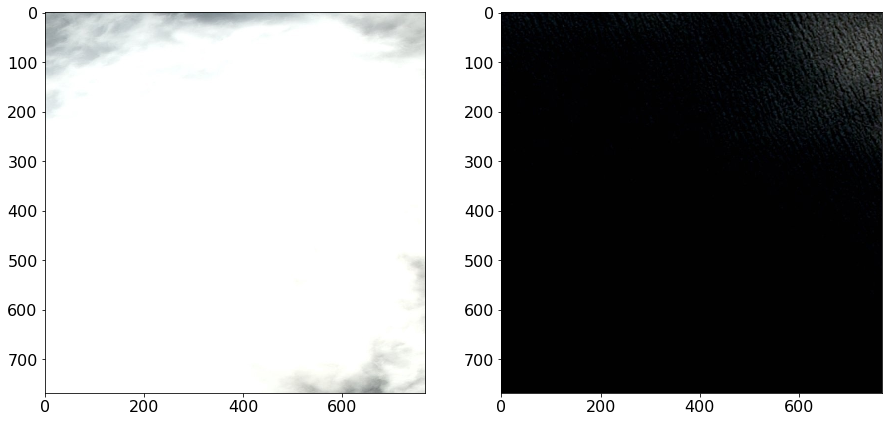

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
img1 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, dup_files[0])), cv2.COLOR_BGR2RGB)
ax1.imshow(img1)
img2 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, dup_files[5])), cv2.COLOR_BGR2RGB)
ax2.imshow(img2)

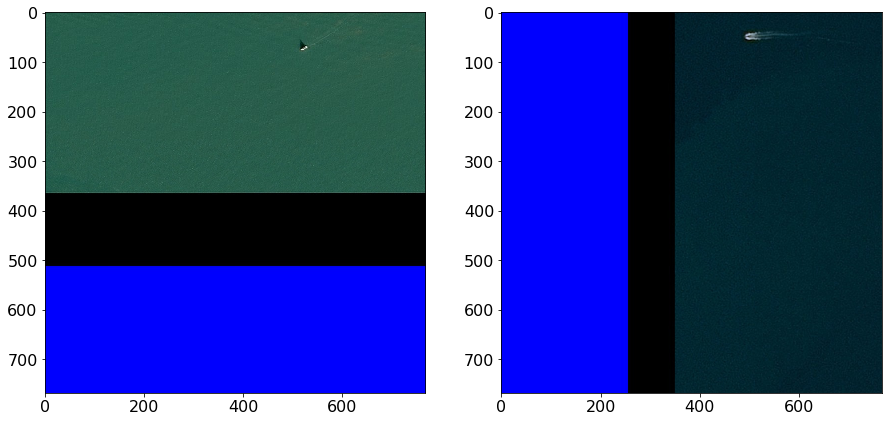

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
img1 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, dup_files[1])), cv2.COLOR_BGR2RGB)
ax1.imshow(img1)
img2 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, dup_files[2])), cv2.COLOR_BGR2RGB)
ax2.imshow(img2)

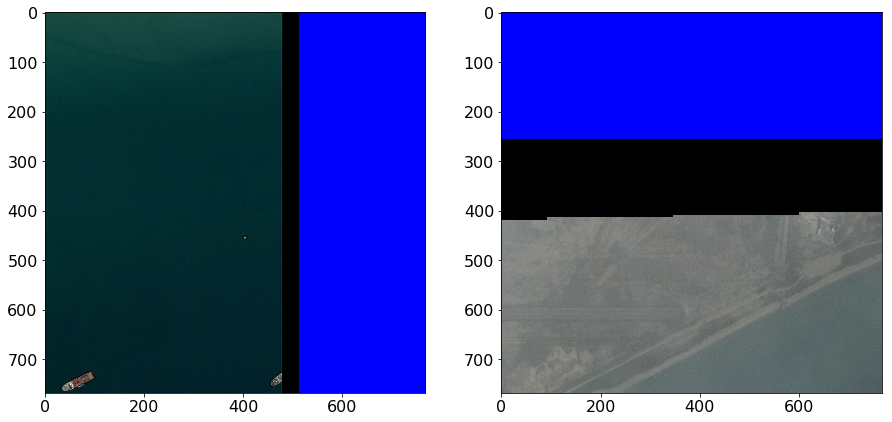

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
img1 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, dup_files[3])), cv2.COLOR_BGR2RGB)
ax1.imshow(img1)
img2 = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, dup_files[4])), cv2.COLOR_BGR2RGB)
ax2.imshow(img2)

In [137]:
black_tile = np.zeros((256, 256, 3), dtype=np.uint8)
white_tile = black_tile + 255
blue_tile = np.copy(black_tile) 
blue_tile[:, :, 0] = 255
red_tile = np.copy(black_tile) 
red_tile[:, :, 2] = 255
color_tiles = [black_tile, white_tile, blue_tile, red_tile]
for color_tile in color_tiles:
    print(img_hash.blockMeanHash(color_tile, mode=0)[0])
    print(hashlib.md5(color_tile.tobytes()).hexdigest())


[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
ef2e0d18474b2151ef5876b1e89c2f1d
[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
0139c6c3c75532c50e37d60a395d9831
[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
52650393d837779f76ffe4db33fd139c
[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
b05a32b99fbe0e7f55268c99cb74e5c3


## (Extra) Left over code to plot ship labels over images

In [ ]:
for key, value in sorted(dup_dict.items(), key=lambda x: x[1][2]):
    has_mask = []
    if value[0]:
        if os.path.exists(os.path.join(train_mask_dir, key[0])):
            has_mask.append(1)
        else:
            has_mask.append(0)
        if os.path.exists(os.path.join(train_mask_dir, key[1])):
            has_mask.append(1)
        else:
            has_mask.append(0)
        print(f'{key[0]}, {has_mask[0]}, {key[1]}, {has_mask[1]}')

In [ ]:
for (img_id1, img_id2), (is_dup, tiles_score, tiles_score1) in dup_dict.items():
    if is_dup == 0:
        continue
    has_mask = 0
    if os.path.exists(os.path.join(train_mask_dir, img_id1)):
        has_mask += 1
    if os.path.exists(os.path.join(train_mask_dir, img_id2)):
        has_mask += 1
    if has_mask == 0:
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    img1 = cv2.imread(os.path.join(train_image_dir, img_id1))
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    ax1.imshow(img1)
    title1 = f'({tiles_score:7.5f}) {img_id1}'
    if os.path.exists(os.path.join(train_mask_dir, img_id1)):
        mask1 = cv2.imread(os.path.join(train_mask_dir, img_id1))
        mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
        ax1.imshow(mask1[..., 0], alpha=0.5)
    ax1.set_title(title1)
    
    img2 = cv2.imread(os.path.join(train_image_dir, img_id2))
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    ax2.imshow(img2)
    title2 = f'({tiles_score1:7.5f}) {img_id2}'
    if os.path.exists(os.path.join(train_mask_dir, img_id2)):
        mask2 = cv2.imread(os.path.join(train_mask_dir, img_id2))
        mask2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2RGB)
        ax2.imshow(mask2[..., 0], alpha=0.5)
    ax2.set_title(title2)
    
    fig.savefig(os.path.join('temp', f"{img_id1}_{img_id2}_mask.jpg"));
    fig.clear();